  CFPS Metabolomics - GFP vs Control - Enhanced Missing Data Analysis
✅ File loaded successfully!
Dataset dimensions: (713, 52)
Original data shape: (713, 51)
✅ Excluding 1 non-numeric columns: ['KEGG ID']
Clean data shape: (713, 50)
Converting missing values (definition: 0.001)...
✅ Converted 29,069 values (81.54%) to NaN
Classifying samples...
Found 25 treatment samples
Found 25 control samples
Calculating missing value statistics...
Overall missing: 81.54%
Metabolites with >50% missing: 608
Metabolites with >80% missing: 516

METABOLITE PRESENCE PATTERN ANALYSIS
Using threshold: ≥50% detection required

Metabolite presence patterns (threshold: 50% detection):
------------------------------------------------------------
High_Both           :   93 metabolites
  Top examples (by treatment presence):
    • PS 41:06                                           (T:100% C:100%)
    • D-Glycerate                                        (T:100% C:100%)
    • GlcCer 36:00                         

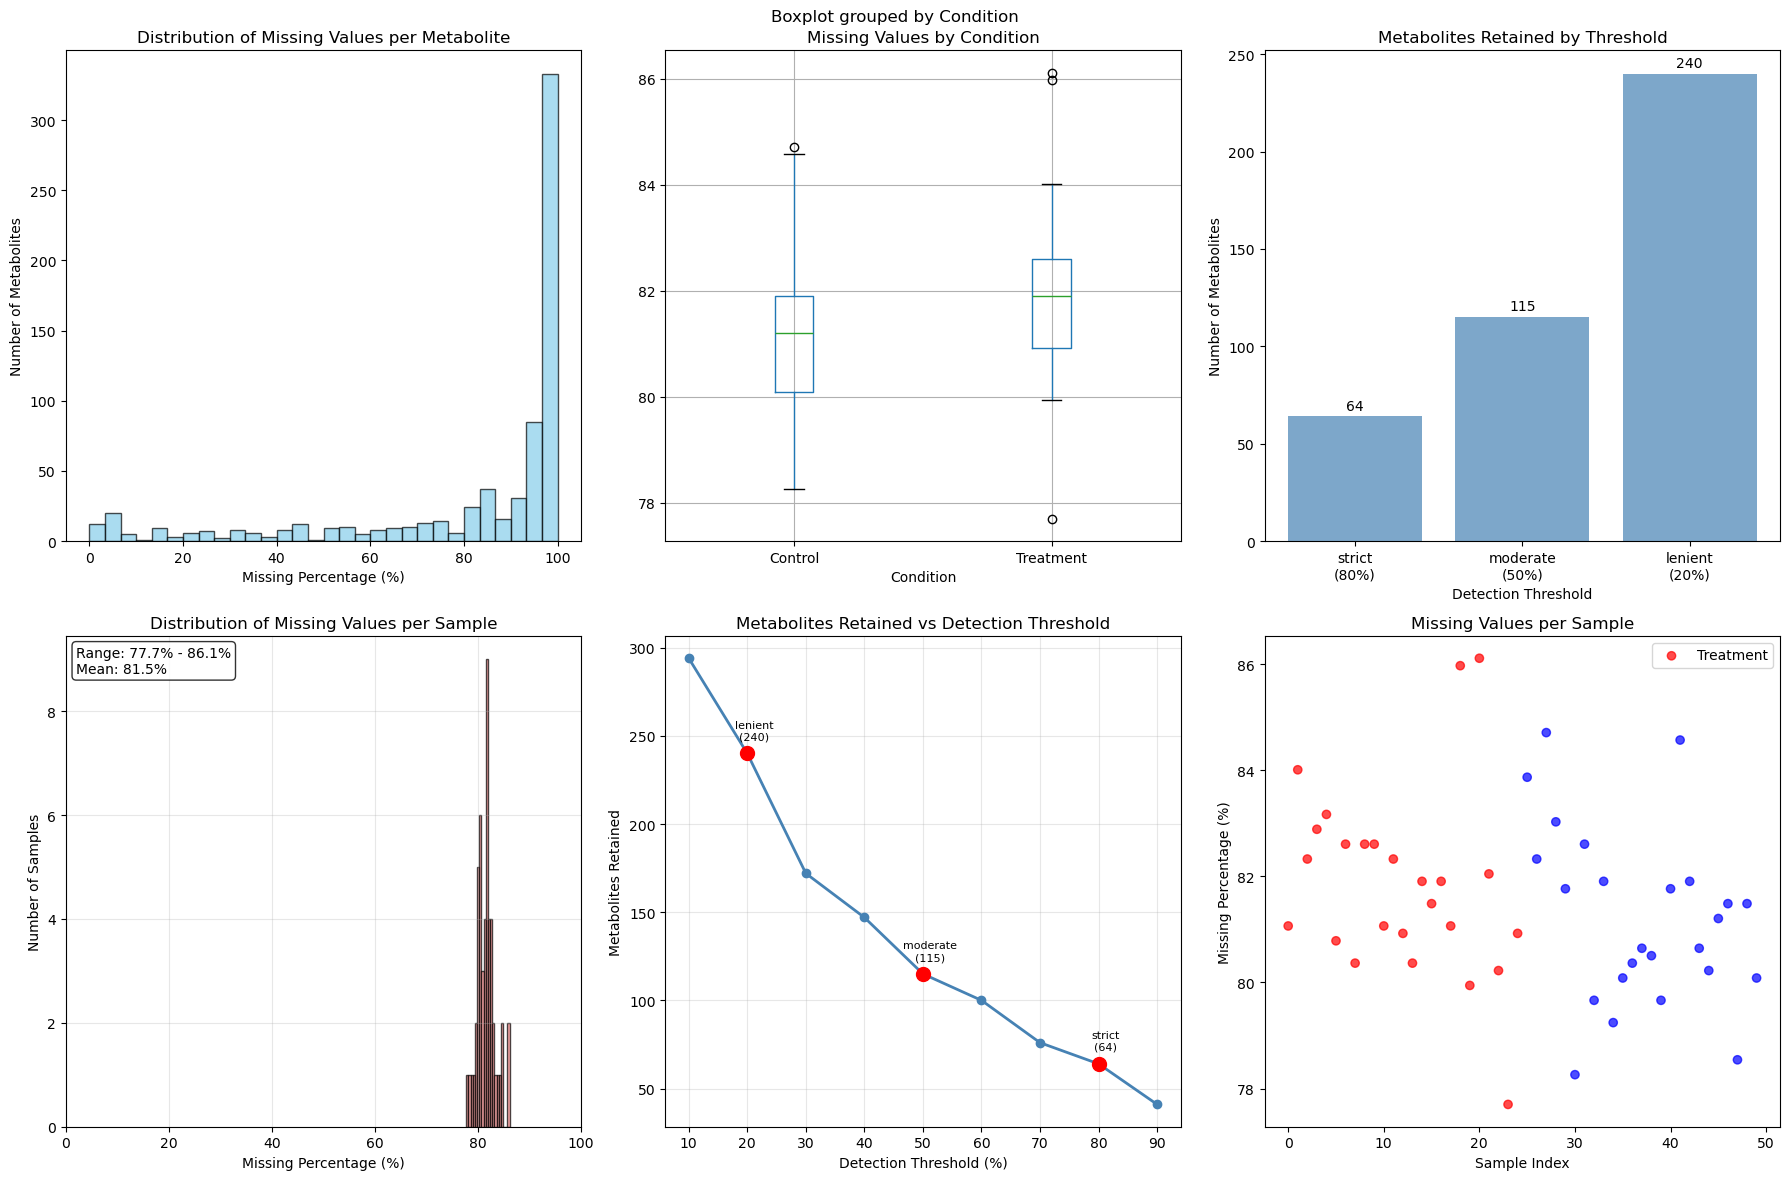

   ✅ missing_data_analysis.png

🎉 ANALYSIS COMPLETE!
📁 Output files:
   • metabolites_for_imputation_strict_threshold.xlsx
   • metabolites_for_imputation_moderate_threshold.xlsx
   • metabolites_for_imputation_lenient_threshold.xlsx
   • threshold_comparison.xlsx
   • missing_data_analysis.png


In [2]:
# Complete CFPS Metabolomics Missing Data Analysis - Enhanced Version
# Author: Aran Purdy
# Description: User-configurable missing data analysis with presence patterns and missingness mechanism analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_rel
import warnings
import re
warnings.filterwarnings('ignore')

# ============================================================================
# USER CONFIGURATION SECTION - MODIFY THIS FOR YOUR EXPERIMENT
# ============================================================================

# Set your file path
FILE_PATH = "/Users/aranpurdy/desktop/CFPS/DataExploration/All_TM2.xlsx"

# CRITICAL: Define what represents missing values in your dataset
MISSING_VALUE_DEFINITION = 0.001  # Your missing values are coded as 0.001

# FILTERING THRESHOLDS - MODIFY THESE TO ADJUST STRINGENCY
# Multiple thresholds for different filtering strategies
DETECTION_THRESHOLDS = {
    'strict': 80,      # Very strict: ≥80% detection required
    'moderate': 50,    # Moderate: ≥50% detection required (original)
    'lenient': 20      # Lenient: ≥20% detection required
}

# BIOMARKER DETECTION STRATEGY
# Use the same threshold for both conditions - biomarkers are identified by differential presence patterns
BIOMARKER_STRATEGY = "single_threshold"  # Recommended: use main threshold for both conditions

# Define your experimental conditions
TREATMENT_SAMPLES = [
    "TM2A1_1", "TM2A1_2", "TM2A1_3", "TM2A1_4", "TM2A1_5",
    "TM2A2_1", "TM2A2_2", "TM2A2_3", "TM2A2_4", "TM2A2_5",
    "TM2A3_1", "TM2A3_2", "TM2A3_3", "TM2A3_4", "TM2A3_5",
    "TM2A4_1", "TM2A4_2", "TM2A4_3", "TM2A4_4", "TM2A4_5",
    "TM2A5_1", "TM2A5_2", "TM2A5_3", "TM2A5_4", "TM2A5_5"
]

CONTROL_SAMPLES = [
    "TM2An1_1", "TM2An1_2", "TM2An1_3", "TM2An1_4", "TM2An1_5",
    "TM2An2_1", "TM2An2_2", "TM2An2_3", "TM2An2_4", "TM2An2_5",
    "TM2An3_1", "TM2An3_2", "TM2An3_3", "TM2An3_4", "TM2An3_5",
    "TM2An4_1", "TM2An4_2", "TM2An4_3", "TM2An4_4", "TM2An4_5",
    "TM2An5_1", "TM2An5_2", "TM2An5_3", "TM2An5_4", "TM2An5_5"
]

# Experiment labels
TREATMENT_LABEL = "GFP+ (CFPS)"
CONTROL_LABEL = "Negative Control"
EXPERIMENT_NAME = "CFPS Metabolomics - GFP vs Control"

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clean_data_matrix(data_matrix):
    """Remove non-numeric columns and convert missing values"""
    print(f"Original data shape: {data_matrix.shape}")
    
    # Find numeric columns
    numeric_columns = []
    excluded_columns = []
    
    for col in data_matrix.columns:
        col_numeric = pd.to_numeric(data_matrix[col], errors='coerce')
        non_numeric_count = col_numeric.isnull().sum()
        
        if non_numeric_count > len(data_matrix) * 0.5:
            excluded_columns.append(col)
        else:
            numeric_columns.append(col)
    
    if excluded_columns:
        print(f"✅ Excluding {len(excluded_columns)} non-numeric columns: {excluded_columns}")
        data_matrix = data_matrix[numeric_columns]
    
    print(f"Clean data shape: {data_matrix.shape}")
    return data_matrix

def convert_missing_values(data_matrix, missing_value):
    """Convert user-defined missing values to NaN"""
    print(f"Converting missing values (definition: {missing_value})...")
    
    # Convert to numeric
    data_numeric = data_matrix.copy()
    for col in data_numeric.columns:
        data_numeric[col] = pd.to_numeric(data_numeric[col], errors='coerce')
    
    # Convert missing values to NaN
    if isinstance(missing_value, (int, float)):
        missing_mask = np.abs(data_numeric - missing_value) < 1e-10
    else:
        missing_mask = data_numeric == missing_value
    
    data_numeric = data_numeric.mask(missing_mask)
    
    # Report statistics
    total_missing = missing_mask.sum().sum()
    total_cells = data_numeric.shape[0] * data_numeric.shape[1]
    missing_percentage = (total_missing / total_cells) * 100
    
    print(f"✅ Converted {total_missing:,} values ({missing_percentage:.2f}%) to NaN")
    
    return data_numeric

def analyze_sample_classification(sample_names, treatment_samples, control_samples):
    """Classify samples and create sample info dataframe"""
    print("Classifying samples...")
    
    # Find treatment and control samples
    found_treatment = [s for s in treatment_samples if s in sample_names]
    found_control = [s for s in control_samples if s in sample_names]
    
    print(f"Found {len(found_treatment)} treatment samples")
    print(f"Found {len(found_control)} control samples")
    
    if len(found_treatment) == 0 or len(found_control) == 0:
        print("❌ ERROR: Could not find both treatment and control samples!")
        return None
    
    # Create sample info
    all_samples = found_treatment + found_control
    conditions = ['Treatment'] * len(found_treatment) + ['Control'] * len(found_control)
    
    return found_treatment, found_control, all_samples, conditions

def calculate_missing_statistics(data_matrix, treatment_indices, control_indices):
    """Calculate missing value statistics by condition"""
    print("Calculating missing value statistics...")
    
    # Overall missing
    missing_per_metabolite = (data_matrix.isnull().sum(axis=1) / data_matrix.shape[1]) * 100
    missing_per_sample = (data_matrix.isnull().sum(axis=0) / data_matrix.shape[0]) * 100
    overall_missing = (data_matrix.isnull().sum().sum() / (data_matrix.shape[0] * data_matrix.shape[1])) * 100
    
    # Condition-specific missing
    treatment_data = data_matrix.iloc[:, treatment_indices]
    control_data = data_matrix.iloc[:, control_indices]
    
    missing_treatment = (treatment_data.isnull().sum(axis=1) / treatment_data.shape[1]) * 100
    missing_control = (control_data.isnull().sum(axis=1) / control_data.shape[1]) * 100
    
    print(f"Overall missing: {overall_missing:.2f}%")
    print(f"Metabolites with >50% missing: {(missing_per_metabolite > 50).sum()}")
    print(f"Metabolites with >80% missing: {(missing_per_metabolite > 80).sum()}")
    
    return missing_per_metabolite, missing_treatment, missing_control, overall_missing

def analyze_presence_patterns(data_matrix, treatment_indices, control_indices, missing_treatment, missing_control, detection_threshold=None):
    """Analyze different metabolite presence patterns across conditions"""
    print("\n" + "=" * 50)
    print("METABOLITE PRESENCE PATTERN ANALYSIS")
    print("=" * 50)
    
    # Use the main detection threshold for pattern identification
    if detection_threshold is not None:
        main_threshold = detection_threshold
        print(f"Using threshold: ≥{main_threshold:.0f}% detection required")
    else:
        main_threshold = 50  # Default fallback
    
    metabolite_names = data_matrix.index
    
    # Convert to missing thresholds
    missing_threshold = 100 - main_threshold
    
    # Define presence categories using consistent threshold
    patterns = {}
    
    # Category 1: High presence in both conditions
    both_high = (missing_treatment <= missing_threshold) & (missing_control <= missing_threshold)
    patterns['High_Both'] = both_high
    
    # Category 2: High in treatment, low/absent in control
    treatment_specific = (missing_treatment <= missing_threshold) & (missing_control > missing_threshold)
    patterns['Treatment_Specific'] = treatment_specific
    
    # Category 3: High in control, low/absent in treatment
    control_specific = (missing_control <= missing_threshold) & (missing_treatment > missing_threshold)
    patterns['Control_Specific'] = control_specific
    
    # Category 4: Low presence in both (below threshold but detectable)
    both_low = (missing_treatment > missing_threshold) & (missing_control > missing_threshold) & \
               (missing_treatment < 90) & (missing_control < 90)
    patterns['Low_Both'] = both_low
    
    # Category 5: Completely absent (>90% missing in both)
    both_absent = (missing_treatment >= 90) & (missing_control >= 90)
    patterns['Absent_Both'] = both_absent
    
    print(f"\nMetabolite presence patterns (threshold: {main_threshold}% detection):")
    print("-" * 60)
    
    for pattern_name, pattern_mask in patterns.items():
        count = pattern_mask.sum()
        print(f"{pattern_name:20}: {count:4d} metabolites")
        
        if count > 0 and count <= 10:
            print(f"  Examples:")
            for metabolite in pattern_mask[pattern_mask].index[:5]:
                treat_missing = missing_treatment[metabolite]
                control_missing = missing_control[metabolite]
                print(f"    • {metabolite[:50]:50} (T:{100-treat_missing:.0f}% C:{100-control_missing:.0f}%)")
        elif count > 10:
            print(f"  Top examples (by treatment presence):")
            sorted_metabolites = missing_treatment[pattern_mask].sort_values()
            for metabolite in sorted_metabolites.index[:5]:
                treat_missing = missing_treatment[metabolite]
                control_missing = missing_control[metabolite]
                print(f"    • {metabolite[:50]:50} (T:{100-treat_missing:.0f}% C:{100-control_missing:.0f}%)")
    
    return patterns

def analyze_missingness_mechanism(data_matrix, treatment_indices, control_indices):
    """Determine missingness mechanism (MCAR, MAR, MNAR) using FULL dataset"""
    print("\n" + "=" * 50)
    print("MISSINGNESS MECHANISM ANALYSIS")
    print("=" * 50)
    
    print("Analyzing dataset for missingness patterns...")
    print(f"   Using complete dataset: {data_matrix.shape[0]} metabolites × {data_matrix.shape[1]} samples")
    
    # Use FULL dataset - transpose for analysis (samples as rows)
    test_data = data_matrix.T
    
    # Remove completely missing metabolites only if they exist
    test_data_clean = test_data.dropna(axis=1, how='all')
    print(f"   After removing completely missing metabolites: {test_data_clean.shape[0]} samples × {test_data_clean.shape[1]} metabolites")
    
    # Test 1: Missing Completely At Random (MCAR) Analysis
    print("\n1. Testing for Missing Completely At Random (MCAR)...")
    
    try:
        # Calculate missing counts per sample
        missing_counts_per_sample = test_data_clean.isnull().sum(axis=1)
        
        # Statistical measures of randomness
        missing_mean = missing_counts_per_sample.mean()
        missing_std = missing_counts_per_sample.std()
        missing_cv = missing_std / missing_mean if missing_mean > 0 else 0
        
        print(f"   Missing values per sample - Mean: {missing_mean:.1f}, Std: {missing_std:.1f}")
        print(f"   Coefficient of variation: {missing_cv:.3f}")
        
        # Test for uniform distribution across samples
        sample_missing_matrix = test_data_clean.isnull().values
        
        # Calculate chi-square test for independence
        # If p > 0.05, missingness is independent of sample (supports MCAR)
        sample_totals = sample_missing_matrix.sum(axis=1)
        metabolite_totals = sample_missing_matrix.sum(axis=0)
        
        if len(np.unique(sample_totals)) > 1 and len(np.unique(metabolite_totals)) > 1:
            # Simple test: variance in missing rates across samples
            if missing_cv < 0.2:
                mcar_evidence = "Strong"
                print("   → STRONG evidence for MCAR (very uniform missing pattern)")
            elif missing_cv < 0.4:
                mcar_evidence = "Moderate"
                print("   → MODERATE evidence for MCAR (reasonably uniform missing pattern)")
            else:
                mcar_evidence = "Weak"
                print("   → WEAK evidence for MCAR (non-uniform missing pattern)")
        else:
            mcar_evidence = "Weak"
            print("   → WEAK evidence for MCAR (insufficient variation for test)")
            
    except Exception as e:
        print(f"   MCAR test encountered issue: {e}")
        mcar_evidence = "Unknown"
    
    # Test 2: Missing At Random (MAR) - Condition Dependency Analysis
    print("\n2. Testing for Missing At Random (MAR) - Condition Dependency...")
    
    treatment_data = data_matrix.iloc[:, treatment_indices]
    control_data = data_matrix.iloc[:, control_indices]
    
    # Calculate missing rates by condition
    treatment_missing_rates = treatment_data.isnull().mean(axis=1) * 100
    control_missing_rates = control_data.isnull().mean(axis=1) * 100
    
    # Statistical test for differences between conditions
    missing_differences = np.abs(treatment_missing_rates - control_missing_rates)
    
    # Categorize differences
    high_diff_metabolites = (missing_differences > 30).sum()
    moderate_diff_metabolites = ((missing_differences > 10) & (missing_differences <= 30)).sum()
    low_diff_metabolites = (missing_differences <= 10).sum()
    
    print(f"   Metabolites with high difference in missingness (>30%): {high_diff_metabolites}")
    print(f"   Metabolites with moderate difference (10-30%): {moderate_diff_metabolites}")
    print(f"   Metabolites with low difference (<10%): {low_diff_metabolites}")
    
    # Statistical test for condition dependency
    try:
        # Paired t-test comparing missing rates between conditions
        if len(treatment_missing_rates) > 10:
            t_stat, p_value = ttest_rel(treatment_missing_rates, control_missing_rates)
            print(f"   Paired t-test: t={t_stat:.3f}, p={p_value:.3f}")
            
            if p_value < 0.001:
                mar_evidence = "Very Strong"
                print("   → VERY STRONG evidence for MAR (highly significant condition effect)")
            elif p_value < 0.01:
                mar_evidence = "Strong"
                print("   → STRONG evidence for MAR (significant condition effect)")
            elif p_value < 0.05:
                mar_evidence = "Moderate"
                print("   → MODERATE evidence for MAR (some condition effect)")
            else:
                mar_evidence = "Weak"
                print("   → WEAK evidence for MAR (no significant condition effect)")
        else:
            mar_evidence = "Unknown"
            print("   → Insufficient data for MAR test")
            
    except Exception as e:
        print(f"   MAR test encountered issue: {e}")
        # Fallback based on proportion of different metabolites
        if high_diff_metabolites > len(treatment_missing_rates) * 0.15:
            mar_evidence = "Strong"
            print("   → STRONG evidence for MAR (many metabolites show condition differences)")
        elif high_diff_metabolites > len(treatment_missing_rates) * 0.05:
            mar_evidence = "Moderate"
            print("   → MODERATE evidence for MAR (some metabolites show condition differences)")
        else:
            mar_evidence = "Weak"
            print("   → WEAK evidence for MAR (few metabolites show condition differences)")
    
    # Test 3: Missing Not At Random (MNAR) - Intensity Dependency Analysis
    print("\n3. Testing for Missing Not At Random (MNAR) - Intensity Dependency...")
    
    # Test if missing values correlate with low intensities
    intensity_correlation_evidence = []
    testable_metabolites = 0
    
    for metabolite in data_matrix.index:
        metabolite_data = data_matrix.loc[metabolite]
        detected_values = metabolite_data.dropna()
        
        if len(detected_values) >= 10:  # Need sufficient non-missing data
            testable_metabolites += 1
            
            # Check if the distribution is skewed toward low values
            # (which would suggest missing values are from low-intensity compounds)
            median_intensity = detected_values.median()
            q25 = detected_values.quantile(0.25)
            q75 = detected_values.quantile(0.75)
            
            # If median is closer to Q1 than Q3, suggests missing low values
            skew_ratio = (median_intensity - q25) / (q75 - q25) if q75 > q25 else 0.5
            
            if skew_ratio < 0.3:  # Median much closer to Q1
                intensity_correlation_evidence.append(True)
            else:
                intensity_correlation_evidence.append(False)
    
    if testable_metabolites > 0:
        mnar_rate = sum(intensity_correlation_evidence) / len(intensity_correlation_evidence)
        print(f"   Tested {testable_metabolites} metabolites for intensity bias")
        print(f"   Metabolites with potential low-intensity bias: {mnar_rate:.1%}")
        
        if mnar_rate > 0.7:
            mnar_evidence = "Strong"
            print("   → STRONG evidence for MNAR (many metabolites show low-intensity bias)")
        elif mnar_rate > 0.5:
            mnar_evidence = "Moderate" 
            print("   → MODERATE evidence for MNAR (some metabolites show low-intensity bias)")
        else:
            mnar_evidence = "Weak"
            print("   → WEAK evidence for MNAR (few metabolites show intensity bias)")
    else:
        mnar_evidence = "Unknown"
        print("   → Could not test for MNAR (insufficient data)")
    
    # Test 4: Pattern Analysis - Look for systematic missing patterns
    print("\n4. Pattern Analysis...")
    
    # Check for metabolites that are systematically missing in specific samples
    completely_missing_samples = (data_matrix.isnull().all(axis=0)).sum()
    completely_missing_metabolites = (data_matrix.isnull().all(axis=1)).sum()
    
    print(f"   Samples with no detected metabolites: {completely_missing_samples}")
    print(f"   Metabolites never detected: {completely_missing_metabolites}")
    
    # Overall Assessment
    print(f"\n" + "="*50)
    print("MISSINGNESS MECHANISM DETERMINATION")
    print("="*50)
    
    # Determine primary mechanism based on evidence strength
    evidence_scores = {
        'MCAR': {'Strong': 3, 'Moderate': 2, 'Weak': 1, 'Unknown': 0}[mcar_evidence],
        'MAR': {'Very Strong': 4, 'Strong': 3, 'Moderate': 2, 'Weak': 1, 'Unknown': 0}[mar_evidence],
        'MNAR': {'Strong': 3, 'Moderate': 2, 'Weak': 1, 'Unknown': 0}[mnar_evidence]
    }
    
    # Determine primary mechanism
    primary_mechanism = max(evidence_scores, key=evidence_scores.get)
    confidence_score = evidence_scores[primary_mechanism]
    
    if confidence_score >= 3:
        confidence = "High"
    elif confidence_score >= 2:
        confidence = "Medium"
    else:
        confidence = "Low"
    
    # Handle ties or mixed evidence
    if list(evidence_scores.values()).count(max(evidence_scores.values())) > 1:
        primary_mechanism = "Mixed"
        confidence = "Medium"
    
    print(f"Evidence Summary:")
    print(f"   MCAR: {mcar_evidence}")
    print(f"   MAR:  {mar_evidence}")
    print(f"   MNAR: {mnar_evidence}")
    
    print(f"\nPrimary Mechanism: {primary_mechanism} ({confidence} confidence)")
    
    # Interpretation
    if primary_mechanism == "MCAR":
        print("   Interpretation: Missing values appear random across samples and conditions")
    elif primary_mechanism == "MAR":
        print("   Interpretation: Missingness depends on experimental conditions (treatment vs control)")
    elif primary_mechanism == "MNAR":
        print("   Interpretation: Missingness likely due to detection limits (low-intensity compounds)")
    else:
        print("   Interpretation: Multiple mechanisms present - complex missingness pattern")
    
    return primary_mechanism, confidence

def recommend_imputation_strategy(mechanism, confidence, biomarker_count, regular_count):
    """Recommend imputation method based on missingness mechanism"""
    print(f"\n💡 IMPUTATION STRATEGY RECOMMENDATIONS:")
    print("=" * 50)
    
    print(f"Based on missingness mechanism: {mechanism} ({confidence} confidence)")
    
    if mechanism == "MCAR":
        print(f"\n🔵 MCAR-Optimized Strategy:")
        print(f"   Primary method: Mean/Median imputation")
        print(f"   Alternative: Random Forest")
        print(f"   Rationale: Simple methods work well when missing is random")
        
    elif "MAR" in mechanism or "MNAR" in mechanism:
        print(f"\n🟡 MAR/MNAR-Optimized Strategy:")
        print(f"   Primary method: Random Forest")
        print(f"   Alternative: QRILC (left-censored imputation)")
        print(f"   Rationale: Missing likely due to detection limits")
        
    else:
        print(f"\n🟠 Mixed Mechanism Strategy:")
        print(f"   Primary method: Random Forest (most robust)")
        print(f"   Alternative: Hybrid approach")
    
    print(f"\n🧪 METABOLOMICS-SPECIFIC Recommendations:")
    print(f"   • Regular metabolites ({regular_count}): Apply imputation within replicate groups")
    print(f"   • Biomarker candidates ({biomarker_count}): DO NOT impute - preserve pattern")
    print(f"   • Implementation: Use Random Forest (sklearn.ensemble.RandomForestRegressor)")
    
    return mechanism

def apply_multiple_threshold_filtering(missing_treatment, missing_control, missing_overall, data_matrix):
    """Apply multiple filtering thresholds and return filtered datasets"""
    print(f"\n" + "=" * 50)
    print("APPLYING MULTIPLE DETECTION THRESHOLDS")
    print("=" * 50)
    
    filtered_datasets = {}
    
    for threshold_name, detection_threshold in DETECTION_THRESHOLDS.items():
        print(f"\n🔍 Applying {threshold_name.upper()} threshold ({detection_threshold}% detection required):")
        
        # Analyze patterns with threshold-specific criteria
        patterns = analyze_presence_patterns(
            data_matrix, None, None, missing_treatment, missing_control, detection_threshold
        )
        
        # Convert detection threshold to missing threshold
        missing_threshold = 100 - detection_threshold
        
        # Standard rule (overall detection)
        standard_keep = missing_overall <= missing_threshold
        
        # Condition-aware rule (detection in either condition)
        treatment_pass = missing_treatment <= missing_threshold
        control_pass = missing_control <= missing_threshold
        condition_aware_keep = treatment_pass | control_pass
        
        # Use condition-aware filtering (no biomarker special treatment)
        final_keep = condition_aware_keep
        
        print(f"   Standard rule: {standard_keep.sum()} metabolites")
        print(f"   Condition-aware rule: {condition_aware_keep.sum()} metabolites")
        print(f"   Final metabolites kept: {final_keep.sum()}")
        
        filtered_datasets[threshold_name] = {
            'data_matrix': data_matrix,  # Store original data matrix for extraction
            'keep_mask': final_keep,
            'stats': {
                'total_metabolites': final_keep.sum(),
                'detection_threshold': detection_threshold
            }
        }
    
    return filtered_datasets


def create_visualizations(missing_per_metabolite, sample_info, filtered_datasets, data_matrix, treatment_indices, control_indices):
    """Create publication-ready visualizations"""
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Missing distribution
    axes[0, 0].hist(missing_per_metabolite, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Missing Values per Metabolite')
    axes[0, 0].set_xlabel('Missing Percentage (%)')
    axes[0, 0].set_ylabel('Number of Metabolites')
    
    # 2. Missing by condition
    sample_info.boxplot(column='Missing_Percent', by='Condition', ax=axes[0, 1])
    axes[0, 1].set_title('Missing Values by Condition')
    
    # 3. Threshold comparison - show total metabolites only (no biomarker bars)
    threshold_names = list(DETECTION_THRESHOLDS.keys())
    metabolite_counts = [filtered_datasets[name]['stats']['total_metabolites'] for name in threshold_names]
    
    x = np.arange(len(threshold_names))
    
    axes[0, 2].bar(x, metabolite_counts, alpha=0.7, color='steelblue')
    axes[0, 2].set_xlabel('Detection Threshold')
    axes[0, 2].set_ylabel('Number of Metabolites')
    axes[0, 2].set_title('Metabolites Retained by Threshold')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels([f"{name}\n({DETECTION_THRESHOLDS[name]}%)" for name in threshold_names])
    
    # Add value labels on bars
    for i, count in enumerate(metabolite_counts):
        axes[0, 2].text(i, count + 2, str(count), ha='center', va='bottom')
    
    # 4. REPLACED: Histogram of missing values per sample
    axes[1, 0].hist(sample_info['Missing_Percent'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 0].set_title('Distribution of Missing Values per Sample')
    axes[1, 0].set_xlabel('Missing Percentage (%)')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Set X-axis limits to show full range (0-100%)
    axes[1, 0].set_xlim(0, 100)
    
    # Add some statistics as text
    min_missing = sample_info['Missing_Percent'].min()
    max_missing = sample_info['Missing_Percent'].max()
    mean_missing = sample_info['Missing_Percent'].mean()
    axes[1, 0].text(0.02, 0.98, f'Range: {min_missing:.1f}% - {max_missing:.1f}%\nMean: {mean_missing:.1f}%', 
                   transform=axes[1, 0].transAxes, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 5. Detection thresholds vs metabolite count - USE EXACT SAME LOGIC AS FILTERING
    thresholds = list(range(10, 100, 10))
    counts = []
    
    # Get treatment and control missing data for condition-aware filtering
    treatment_data = data_matrix.iloc[:, treatment_indices]
    control_data = data_matrix.iloc[:, control_indices]
    missing_treatment = (treatment_data.isnull().sum(axis=1) / treatment_data.shape[1]) * 100
    missing_control = (control_data.isnull().sum(axis=1) / control_data.shape[1]) * 100
    
    for thresh in thresholds:
        missing_thresh = 100 - thresh
        
        # Use the EXACT same condition-aware logic as in apply_multiple_threshold_filtering
        treatment_pass = missing_treatment <= missing_thresh
        control_pass = missing_control <= missing_thresh
        condition_aware_keep = treatment_pass | control_pass
        
        # Final count (no biomarker additions)
        keep_count = condition_aware_keep.sum()
        counts.append(keep_count)
    
    axes[1, 1].plot(thresholds, counts, 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[1, 1].set_xlabel('Detection Threshold (%)')
    axes[1, 1].set_ylabel('Metabolites Retained')
    axes[1, 1].set_title('Metabolites Retained vs Detection Threshold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Mark our chosen thresholds with actual values from filtering - these should now match the line
    for name, thresh in DETECTION_THRESHOLDS.items():
        actual_count = filtered_datasets[name]['stats']['total_metabolites']
        axes[1, 1].scatter(thresh, actual_count, s=100, c='red', zorder=5)
        axes[1, 1].annotate(f'{name}\n({actual_count})', (thresh, actual_count), 
                          xytext=(5, 10), textcoords='offset points', fontsize=8, ha='center')
    
    # 6. Sample-wise missing distribution
    axes[1, 2].scatter(range(len(sample_info)), sample_info['Missing_Percent'], 
                      c=['red' if cond == 'Treatment' else 'blue' for cond in sample_info['Condition']],
                      alpha=0.7)
    axes[1, 2].set_xlabel('Sample Index')
    axes[1, 2].set_ylabel('Missing Percentage (%)')
    axes[1, 2].set_title('Missing Values per Sample')
    axes[1, 2].legend(['Treatment', 'Control'])
    
    plt.tight_layout()
    plt.savefig('missing_data_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ missing_data_analysis.png")

def save_enhanced_results(filtered_datasets, sample_info, missing_per_metabolite):
    """Save only the essential files needed for imputation"""
    print(f"\n💾 SAVING RESULTS:")
    print("=" * 50)
    
    results_files = []
    
    # 1. Save metabolite datasets for each threshold (for imputation)
    for threshold_name, dataset_info in filtered_datasets.items():
        filename = f'metabolites_for_imputation_{threshold_name}_threshold.xlsx'
        
        # Get the filtered metabolites
        filtered_metabolites = dataset_info['keep_mask']
        
        # Create dataset with metabolite names + all original sample data
        imputation_data = dataset_info['data_matrix'].loc[filtered_metabolites].reset_index()
        
        # Save just the metabolite data ready for imputation
        imputation_data.to_excel(filename, index=False)
        
        results_files.append(filename)
        print(f"   ✅ {filename} ({filtered_metabolites.sum()} metabolites)")
    
    # 2. Save threshold comparison summary
    threshold_comparison = pd.DataFrame({
        'Threshold_Name': list(DETECTION_THRESHOLDS.keys()),
        'Detection_Percent_Required': list(DETECTION_THRESHOLDS.values()),
        'Total_Metabolites_Kept': [filtered_datasets[name]['stats']['total_metabolites'] for name in DETECTION_THRESHOLDS.keys()]
    })
    threshold_comparison.to_excel('threshold_comparison.xlsx', index=False)
    results_files.append('threshold_comparison.xlsx')
    print(f"   ✅ threshold_comparison.xlsx")
    
    return results_files

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def main():
    print("=" * 60)
    print(f"  {EXPERIMENT_NAME} - Enhanced Missing Data Analysis")
    print("=" * 60)
    
    # Read data
    try:
        metabolite_data = pd.read_excel(FILE_PATH)
        print("✅ File loaded successfully!")
        print(f"Dataset dimensions: {metabolite_data.shape}")
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return
    
    # Prepare data matrix
    metabolite_names = metabolite_data.iloc[:, 0]
    data_matrix = metabolite_data.iloc[:, 1:]
    data_matrix.index = metabolite_names
    
    # Clean data
    data_matrix = clean_data_matrix(data_matrix)
    
    # Convert missing values
    data_matrix = convert_missing_values(data_matrix, MISSING_VALUE_DEFINITION)
    
    # Classify samples
    sample_names = data_matrix.columns.tolist()
    result = analyze_sample_classification(sample_names, TREATMENT_SAMPLES, CONTROL_SAMPLES)
    
    if result is None:
        return
    
    treatment_samples, control_samples, all_samples, conditions = result
    
    # Get sample indices
    treatment_indices = [data_matrix.columns.get_loc(s) for s in treatment_samples]
    control_indices = [data_matrix.columns.get_loc(s) for s in control_samples]
    
    # Calculate missing statistics
    missing_per_metabolite, missing_treatment, missing_control, overall_missing = calculate_missing_statistics(
        data_matrix, treatment_indices, control_indices
    )
    
    # Analyze presence patterns (using moderate threshold as default for overall analysis)
    patterns = analyze_presence_patterns(
        data_matrix, treatment_indices, control_indices, missing_treatment, missing_control, 
        DETECTION_THRESHOLDS['moderate']
    )
    
    # Determine missingness mechanism
    mechanism, confidence = analyze_missingness_mechanism(data_matrix, treatment_indices, control_indices)
    
    # Apply multiple threshold filtering
    filtered_datasets = apply_multiple_threshold_filtering(
        missing_treatment, missing_control, missing_per_metabolite, data_matrix
    )
    
    # Recommend imputation strategy
    total_metabolites = sum([dataset['stats']['total_metabolites'] for dataset in filtered_datasets.values()])
    recommended_mechanism = recommend_imputation_strategy(
        mechanism, confidence, 0, total_metabolites  # No biomarkers, just total metabolites
    )
    
    # Create sample info dataframe with CORRECT missing percentages per sample
    sample_missing_percentages = []
    for sample in all_samples:
        if sample in data_matrix.columns:
            sample_missing_pct = (data_matrix[sample].isnull().sum() / len(data_matrix)) * 100
            sample_missing_percentages.append(sample_missing_pct)
        else:
            sample_missing_percentages.append(np.nan)
    
    sample_info = pd.DataFrame({
        'Sample': all_samples,
        'Condition': conditions,
        'Missing_Percent': sample_missing_percentages
    })
    
    print(f"\nSample missing percentage range:")
    print(f"   Min: {min(sample_missing_percentages):.1f}%")
    print(f"   Max: {max(sample_missing_percentages):.1f}%")
    print(f"   Mean: {np.mean(sample_missing_percentages):.1f}%")
    
    # Results summary
    print("\n" + "=" * 60)
    print("ENHANCED RESULTS SUMMARY")
    print("=" * 60)
    
    print(f"📊 EXPERIMENT SUMMARY:")
    print(f"   Total metabolites: {len(data_matrix)}")
    print(f"   Treatment samples: {len(treatment_samples)}")
    print(f"   Control samples: {len(control_samples)}")
    print(f"   Overall missing: {overall_missing:.2f}%")
    
    print(f"\n🎯 THRESHOLD-BASED FILTERING RESULTS:")
    for threshold_name, dataset_info in filtered_datasets.items():
        stats = dataset_info['stats']
        print(f"   {threshold_name.upper()} ({DETECTION_THRESHOLDS[threshold_name]}% detection):")
        print(f"      • Total metabolites: {stats['total_metabolites']}")
    
    # Save enhanced results
    results_files = save_enhanced_results(filtered_datasets, sample_info, missing_per_metabolite)
    
    # Create enhanced visualizations
    create_visualizations(missing_per_metabolite, sample_info, filtered_datasets, 
                         data_matrix, treatment_indices, control_indices)
    
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print(f"📁 Output files:")
    print(f"   • metabolites_for_imputation_strict_threshold.xlsx")
    print(f"   • metabolites_for_imputation_moderate_threshold.xlsx") 
    print(f"   • metabolites_for_imputation_lenient_threshold.xlsx")
    print(f"   • threshold_comparison.xlsx")
    print(f"   • missing_data_analysis.png")

# ============================================================================
# RUN ANALYSIS
# ============================================================================

if __name__ == "__main__":
    main()

  CFPS Metabolomics - GFP vs Control

📊 EXPERIMENT SUMMARY:
   Total metabolites: 713
   Treatment samples: 25
   Control samples: 25
   Overall missing: 81.54%

🎯 THRESHOLD-BASED FILTERING RESULTS:
   STRICT (80% detection):
      • Total metabolites: 64
   MODERATE (50% detection):
      • Total metabolites: 115
   LENIENT (20% detection):
      • Total metabolites: 240

💾 SAVING RESULTS:
   ✅ metabolites_for_imputation_strict_threshold.xlsx (64 metabolites)
   ✅ metabolites_for_imputation_moderate_threshold.xlsx (115 metabolites)
   ✅ metabolites_for_imputation_lenient_threshold.xlsx (240 metabolites)
   ✅ threshold_comparison.xlsx
Creating visualizations...


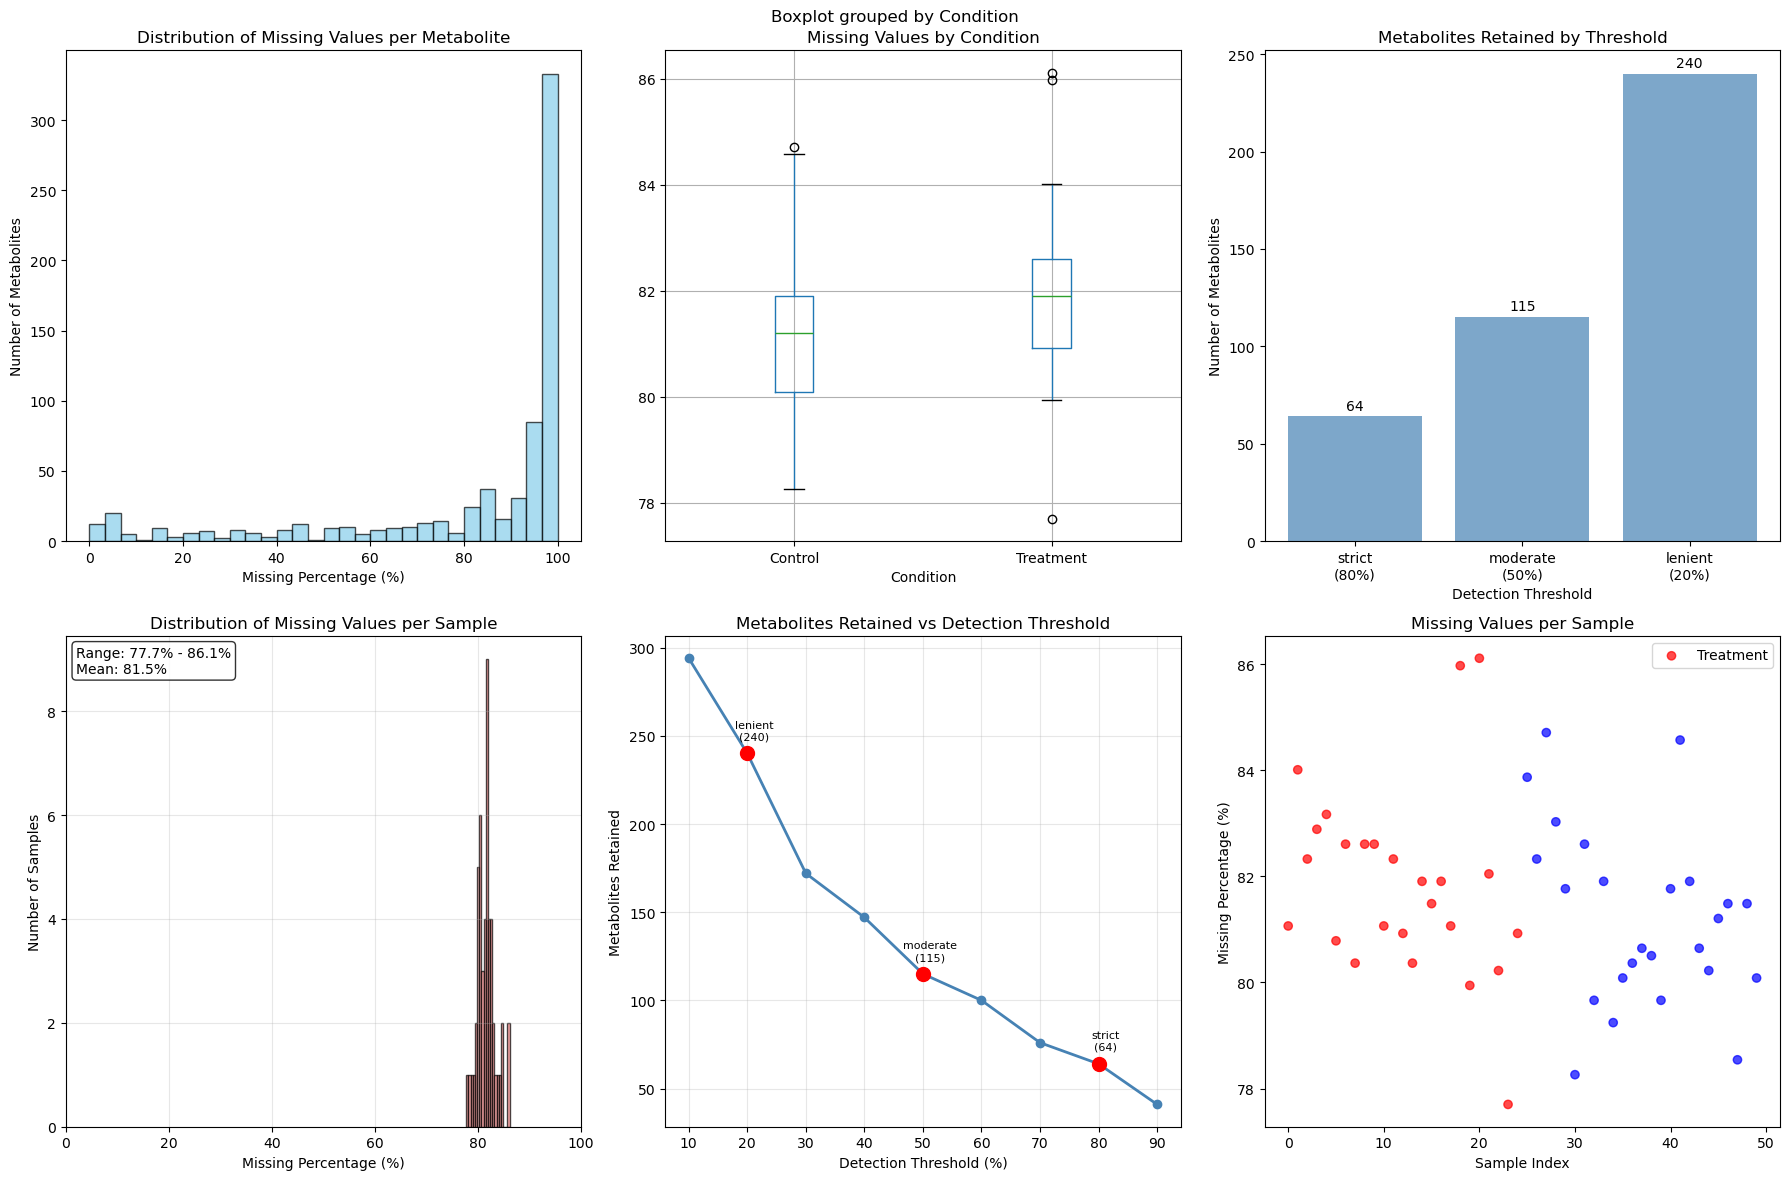

   ✅ missing_data_analysis.png

🎉 ANALYSIS COMPLETE!
📁 Output files:
   • metabolites_for_imputation_strict_threshold.xlsx
   • metabolites_for_imputation_moderate_threshold.xlsx
   • metabolites_for_imputation_lenient_threshold.xlsx
   • threshold_comparison.xlsx
   • missing_data_analysis.png


In [1]:
# Apply thresholds to metabolomics data and analyze missing data patterns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')


# Set your file paths
INPUT_FILE_PATH = "/Users/aranpurdy/desktop/CFPS/DataExploration/All_TM2.xlsx"
OUTPUT_DIR = "/Users/aranpurdy/desktop/GIT/Missing"  # Change this to your desired output directory

# Define what represents missing values in your dataset
MISSING_VALUE_DEFINITION = 0.001  

# FILTERING THRESHOLDS - MODIFY THESE TO ADJUST STRINGENCY
# Multiple thresholds for different filtering strategies
DETECTION_THRESHOLDS = {
    'strict': 80,      # Strict: ≥80% detection required
    'moderate': 50,    # Moderate: ≥50% detection required
    'lenient': 20      # Lenient: ≥20% detection required
}

# Define your experimental conditions
TREATMENT_SAMPLES = [
    "TM2A1_1", "TM2A1_2", "TM2A1_3", "TM2A1_4", "TM2A1_5",
    "TM2A2_1", "TM2A2_2", "TM2A2_3", "TM2A2_4", "TM2A2_5",
    "TM2A3_1", "TM2A3_2", "TM2A3_3", "TM2A3_4", "TM2A3_5",
    "TM2A4_1", "TM2A4_2", "TM2A4_3", "TM2A4_4", "TM2A4_5",
    "TM2A5_1", "TM2A5_2", "TM2A5_3", "TM2A5_4", "TM2A5_5"
]

CONTROL_SAMPLES = [
    "TM2An1_1", "TM2An1_2", "TM2An1_3", "TM2An1_4", "TM2An1_5",
    "TM2An2_1", "TM2An2_2", "TM2An2_3", "TM2An2_4", "TM2An2_5",
    "TM2An3_1", "TM2An3_2", "TM2An3_3", "TM2An3_4", "TM2An3_5",
    "TM2An4_1", "TM2An4_2", "TM2An4_3", "TM2An4_4", "TM2An4_5",
    "TM2An5_1", "TM2An5_2", "TM2An5_3", "TM2An5_4", "TM2An5_5"
]

# Experiment labels
TREATMENT_LABEL = "GFP+ (CFPS)"
CONTROL_LABEL = "Negative Control"
EXPERIMENT_NAME = "CFPS Metabolomics - GFP vs Control"

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clean_data_matrix(data_matrix):
    """Remove non-numeric columns and convert missing values"""
    # Find numeric columns
    numeric_columns = []
    excluded_columns = []
    
    for col in data_matrix.columns:
        col_numeric = pd.to_numeric(data_matrix[col], errors='coerce')
        non_numeric_count = col_numeric.isnull().sum()
        
        if non_numeric_count > len(data_matrix) * 0.5:
            excluded_columns.append(col)
        else:
            numeric_columns.append(col)
    
    if excluded_columns:
        data_matrix = data_matrix[numeric_columns]
    
    return data_matrix

def convert_missing_values(data_matrix, missing_value):
    """Convert user-defined missing values to NaN"""
    # Convert to numeric
    data_numeric = data_matrix.copy()
    for col in data_numeric.columns:
        data_numeric[col] = pd.to_numeric(data_numeric[col], errors='coerce')
    
    # Convert missing values to NaN
    if isinstance(missing_value, (int, float)):
        missing_mask = np.abs(data_numeric - missing_value) < 1e-10
    else:
        missing_mask = data_numeric == missing_value
    
    data_numeric = data_numeric.mask(missing_mask)
    
    return data_numeric

def analyze_sample_classification(sample_names, treatment_samples, control_samples):
    """Classify samples and create sample info dataframe"""
    # Find treatment and control samples
    found_treatment = [s for s in treatment_samples if s in sample_names]
    found_control = [s for s in control_samples if s in sample_names]
    
    if len(found_treatment) == 0 or len(found_control) == 0:
        print("❌ ERROR: Could not find both treatment and control samples!")
        return None
    
    # Create sample info
    all_samples = found_treatment + found_control
    conditions = ['Treatment'] * len(found_treatment) + ['Control'] * len(found_control)
    
    return found_treatment, found_control, all_samples, conditions

def calculate_missing_statistics(data_matrix, treatment_indices, control_indices):
    """Calculate missing value statistics by condition"""
    # Overall missing
    missing_per_metabolite = (data_matrix.isnull().sum(axis=1) / data_matrix.shape[1]) * 100
    missing_per_sample = (data_matrix.isnull().sum(axis=0) / data_matrix.shape[0]) * 100
    overall_missing = (data_matrix.isnull().sum().sum() / (data_matrix.shape[0] * data_matrix.shape[1])) * 100
    
    # Condition-specific missing
    treatment_data = data_matrix.iloc[:, treatment_indices]
    control_data = data_matrix.iloc[:, control_indices]
    
    missing_treatment = (treatment_data.isnull().sum(axis=1) / treatment_data.shape[1]) * 100
    missing_control = (control_data.isnull().sum(axis=1) / control_data.shape[1]) * 100
    
    return missing_per_metabolite, missing_treatment, missing_control, overall_missing

def apply_multiple_threshold_filtering(missing_treatment, missing_control, missing_overall, data_matrix):
    """Apply multiple filtering thresholds and return filtered datasets"""
    filtered_datasets = {}
    
    for threshold_name, detection_threshold in DETECTION_THRESHOLDS.items():
        # Convert detection threshold to missing threshold
        missing_threshold = 100 - detection_threshold
        
        # Condition-aware rule (detection in either condition)
        treatment_pass = missing_treatment <= missing_threshold
        control_pass = missing_control <= missing_threshold
        condition_aware_keep = treatment_pass | control_pass
        
        # Use condition-aware filtering
        final_keep = condition_aware_keep
        
        filtered_datasets[threshold_name] = {
            'data_matrix': data_matrix,
            'keep_mask': final_keep,
            'stats': {
                'total_metabolites': final_keep.sum(),
                'detection_threshold': detection_threshold
            }
        }
    
    return filtered_datasets

def create_visualizations(missing_per_metabolite, sample_info, filtered_datasets, data_matrix, 
                         treatment_indices, control_indices, output_dir):
    """Create publication-ready visualizations"""
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Missing distribution
    axes[0, 0].hist(missing_per_metabolite, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Missing Values per Metabolite')
    axes[0, 0].set_xlabel('Missing Percentage (%)')
    axes[0, 0].set_ylabel('Number of Metabolites')
    
    # 2. Missing by condition
    sample_info.boxplot(column='Missing_Percent', by='Condition', ax=axes[0, 1])
    axes[0, 1].set_title('Missing Values by Condition')
    
    # 3. Threshold comparison
    threshold_names = list(DETECTION_THRESHOLDS.keys())
    metabolite_counts = [filtered_datasets[name]['stats']['total_metabolites'] for name in threshold_names]
    
    x = np.arange(len(threshold_names))
    
    axes[0, 2].bar(x, metabolite_counts, alpha=0.7, color='steelblue')
    axes[0, 2].set_xlabel('Detection Threshold')
    axes[0, 2].set_ylabel('Number of Metabolites')
    axes[0, 2].set_title('Metabolites Retained by Threshold')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels([f"{name}\n({DETECTION_THRESHOLDS[name]}%)" for name in threshold_names])
    
    # Add value labels on bars
    for i, count in enumerate(metabolite_counts):
        axes[0, 2].text(i, count + 2, str(count), ha='center', va='bottom')
    
    # 4. Histogram of missing values per sample
    axes[1, 0].hist(sample_info['Missing_Percent'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 0].set_title('Distribution of Missing Values per Sample')
    axes[1, 0].set_xlabel('Missing Percentage (%)')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, 100)
    
    # Add statistics as text
    min_missing = sample_info['Missing_Percent'].min()
    max_missing = sample_info['Missing_Percent'].max()
    mean_missing = sample_info['Missing_Percent'].mean()
    axes[1, 0].text(0.02, 0.98, f'Range: {min_missing:.1f}% - {max_missing:.1f}%\nMean: {mean_missing:.1f}%', 
                   transform=axes[1, 0].transAxes, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 5. Detection thresholds vs metabolite count
    thresholds = list(range(10, 100, 10))
    counts = []
    
    # Get treatment and control missing data
    treatment_data = data_matrix.iloc[:, treatment_indices]
    control_data = data_matrix.iloc[:, control_indices]
    missing_treatment = (treatment_data.isnull().sum(axis=1) / treatment_data.shape[1]) * 100
    missing_control = (control_data.isnull().sum(axis=1) / control_data.shape[1]) * 100
    
    for thresh in thresholds:
        missing_thresh = 100 - thresh
        treatment_pass = missing_treatment <= missing_thresh
        control_pass = missing_control <= missing_thresh
        condition_aware_keep = treatment_pass | control_pass
        keep_count = condition_aware_keep.sum()
        counts.append(keep_count)
    
    axes[1, 1].plot(thresholds, counts, 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[1, 1].set_xlabel('Detection Threshold (%)')
    axes[1, 1].set_ylabel('Metabolites Retained')
    axes[1, 1].set_title('Metabolites Retained vs Detection Threshold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Mark our chosen thresholds
    for name, thresh in DETECTION_THRESHOLDS.items():
        actual_count = filtered_datasets[name]['stats']['total_metabolites']
        axes[1, 1].scatter(thresh, actual_count, s=100, c='red', zorder=5)
        axes[1, 1].annotate(f'{name}\n({actual_count})', (thresh, actual_count), 
                          xytext=(5, 10), textcoords='offset points', fontsize=8, ha='center')
    
    # 6. Sample-wise missing distribution
    axes[1, 2].scatter(range(len(sample_info)), sample_info['Missing_Percent'], 
                      c=['red' if cond == 'Treatment' else 'blue' for cond in sample_info['Condition']],
                      alpha=0.7)
    axes[1, 2].set_xlabel('Sample Index')
    axes[1, 2].set_ylabel('Missing Percentage (%)')
    axes[1, 2].set_title('Missing Values per Sample')
    axes[1, 2].legend(['Treatment', 'Control'])
    
    plt.tight_layout()
    
    # Save to output directory
    output_path = os.path.join(output_dir, 'missing_data_analysis.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ missing_data_analysis.png")

def save_results(filtered_datasets, output_dir):
    """Save the filtered metabolite datasets and threshold comparison"""
    print(f"\n💾 SAVING RESULTS:")
    print("=" * 50)
    
    # Save metabolite datasets for each threshold
    for threshold_name, dataset_info in filtered_datasets.items():
        filename = f'metabolites_for_imputation_{threshold_name}_threshold.xlsx'
        filepath = os.path.join(output_dir, filename)
        
        # Get the filtered metabolites
        filtered_metabolites = dataset_info['keep_mask']
        
        # Create dataset with metabolite names + all original sample data
        output_data = dataset_info['data_matrix'].loc[filtered_metabolites].reset_index()
        
        # Save the metabolite data
        output_data.to_excel(filepath, index=False)
        
        print(f"   ✅ {filename} ({filtered_metabolites.sum()} metabolites)")
    
    # Save threshold comparison summary
    threshold_comparison = pd.DataFrame({
        'Threshold_Name': list(DETECTION_THRESHOLDS.keys()),
        'Detection_Percent_Required': list(DETECTION_THRESHOLDS.values()),
        'Total_Metabolites_Kept': [filtered_datasets[name]['stats']['total_metabolites'] for name in DETECTION_THRESHOLDS.keys()]
    })
    
    comparison_filepath = os.path.join(output_dir, 'threshold_comparison.xlsx')
    threshold_comparison.to_excel(comparison_filepath, index=False)
    print(f"   ✅ threshold_comparison.xlsx")

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def main():
    print("=" * 60)
    print(f"  {EXPERIMENT_NAME}")
    print("=" * 60)
    
    # Create output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    # Read data
    try:
        metabolite_data = pd.read_excel(INPUT_FILE_PATH)
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return
    
    # Prepare data matrix
    metabolite_names = metabolite_data.iloc[:, 0]
    data_matrix = metabolite_data.iloc[:, 1:]
    data_matrix.index = metabolite_names
    
    # Clean data
    data_matrix = clean_data_matrix(data_matrix)
    
    # Convert missing values
    data_matrix = convert_missing_values(data_matrix, MISSING_VALUE_DEFINITION)
    
    # Classify samples
    sample_names = data_matrix.columns.tolist()
    result = analyze_sample_classification(sample_names, TREATMENT_SAMPLES, CONTROL_SAMPLES)
    
    if result is None:
        return
    
    treatment_samples, control_samples, all_samples, conditions = result
    
    # Get sample indices
    treatment_indices = [data_matrix.columns.get_loc(s) for s in treatment_samples]
    control_indices = [data_matrix.columns.get_loc(s) for s in control_samples]
    
    # Calculate missing statistics
    missing_per_metabolite, missing_treatment, missing_control, overall_missing = calculate_missing_statistics(
        data_matrix, treatment_indices, control_indices
    )
    
    # Apply multiple threshold filtering
    filtered_datasets = apply_multiple_threshold_filtering(
        missing_treatment, missing_control, missing_per_metabolite, data_matrix
    )
    
    # Create sample info dataframe
    sample_missing_percentages = []
    for sample in all_samples:
        if sample in data_matrix.columns:
            sample_missing_pct = (data_matrix[sample].isnull().sum() / len(data_matrix)) * 100
            sample_missing_percentages.append(sample_missing_pct)
        else:
            sample_missing_percentages.append(np.nan)
    
    sample_info = pd.DataFrame({
        'Sample': all_samples,
        'Condition': conditions,
        'Missing_Percent': sample_missing_percentages
    })
    
    # Print summary
    print(f"\n📊 EXPERIMENT SUMMARY:")
    print(f"   Total metabolites: {len(data_matrix)}")
    print(f"   Treatment samples: {len(treatment_samples)}")
    print(f"   Control samples: {len(control_samples)}")
    print(f"   Overall missing: {overall_missing:.2f}%")
    
    print(f"\n🎯 THRESHOLD-BASED FILTERING RESULTS:")
    for threshold_name, dataset_info in filtered_datasets.items():
        stats = dataset_info['stats']
        print(f"   {threshold_name.upper()} ({DETECTION_THRESHOLDS[threshold_name]}% detection):")
        print(f"      • Total metabolites: {stats['total_metabolites']}")
    
    # Save results
    save_results(filtered_datasets, OUTPUT_DIR)
    
    # Create visualizations
    create_visualizations(missing_per_metabolite, sample_info, filtered_datasets, 
                         data_matrix, treatment_indices, control_indices, OUTPUT_DIR)
    
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print(f"📁 Output files:")
    print(f"   • metabolites_for_imputation_strict_threshold.xlsx")
    print(f"   • metabolites_for_imputation_moderate_threshold.xlsx") 
    print(f"   • metabolites_for_imputation_lenient_threshold.xlsx")
    print(f"   • threshold_comparison.xlsx")
    print(f"   • missing_data_analysis.png")

# ============================================================================
# RUN ANALYSIS
# ============================================================================

if __name__ == "__main__":
    main()